### Case Study

Cryptocurrencies have gained significant attention in recent years due to their decentralized nature and potential for high returns. However, the volatility of cryptocurrency prices also presents a substantial challenge, not only for investors aiming to maximize returns but also for those needing precise price predictions for budgeting and financial planning.

In this case study, our goal is to predict the actual price of a cryptocurrency over a specified period using the eXtreme Gradient Boosting (XGBoost) algorithm. XGBoost is renowned for its efficiency and performance in handling complex datasets with high dimensionality, making it an excellent choice for modeling the often unpredictable cryptocurrency market.

By leveraging historical price data along with relevant market indicators, this case study will demonstrate how to train an XGBoost model in a Jupyter Notebook environment to forecast the future prices of a cryptocurrency. Accurate price predictions can provide critical insights for traders and investors, enabling them to make better-informed decisions and manage their financial risks more effectively in the volatile cryptocurrency market.

### Run Once

Built-in Google Colab modules


In [3]:
# %pip install pandas_datareader
# %pip install yfinance
# %pip install scikit-learn
# %pip install xgboost
# %pip install matplotlib

New Modules

In [4]:
# %sudo apt install graphviz # only works on linux
%pip install ta

Note: you may need to restart the kernel to use updated packages.


### Imports

In [5]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Extraction
from pandas_datareader import data as pdr
import yfinance as yfin
# import ccxt
import ta

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold

# Regression Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Extraction and Historical Price Overview


In [6]:
# Settings
is_new_data = False # True if you want to download new data


# Settings if is new data
if is_new_data:
    symbol = "ETH-USD"
    since = "2012-01-01"
    
else:
    symbol = "BTC_USD"

In [7]:
class DataExtraction:
    def get_new_historical_data(self, symbol, since, limit=None):
        yfin.pdr_override()
        df = pdr.get_data_yahoo(symbol, start=since)
        return df
    
    def load_btcusd_historical_data(self):
        df = pd.read_csv('https://raw.githubusercontent.com/Algo-Tradings/XGBoost-Price-Predictor/main/data/BTC-USD.csv')
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        return df
    
    def get_all_ta_features(self, df):
        df = ta.add_all_ta_features(df, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)
        return df

In [8]:
# Data Extraction
extractor = DataExtraction()
if is_new_data:
    extractor_df = extractor.get_new_historical_data(symbol=symbol, since=since)

else:
    extractor_df = extractor.load_btcusd_historical_data()

df_orig = extractor_df.copy()
df_orig

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,67195.867188,44129299406
2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,63821.472656,52869738185
2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,65738.726562,49084320047


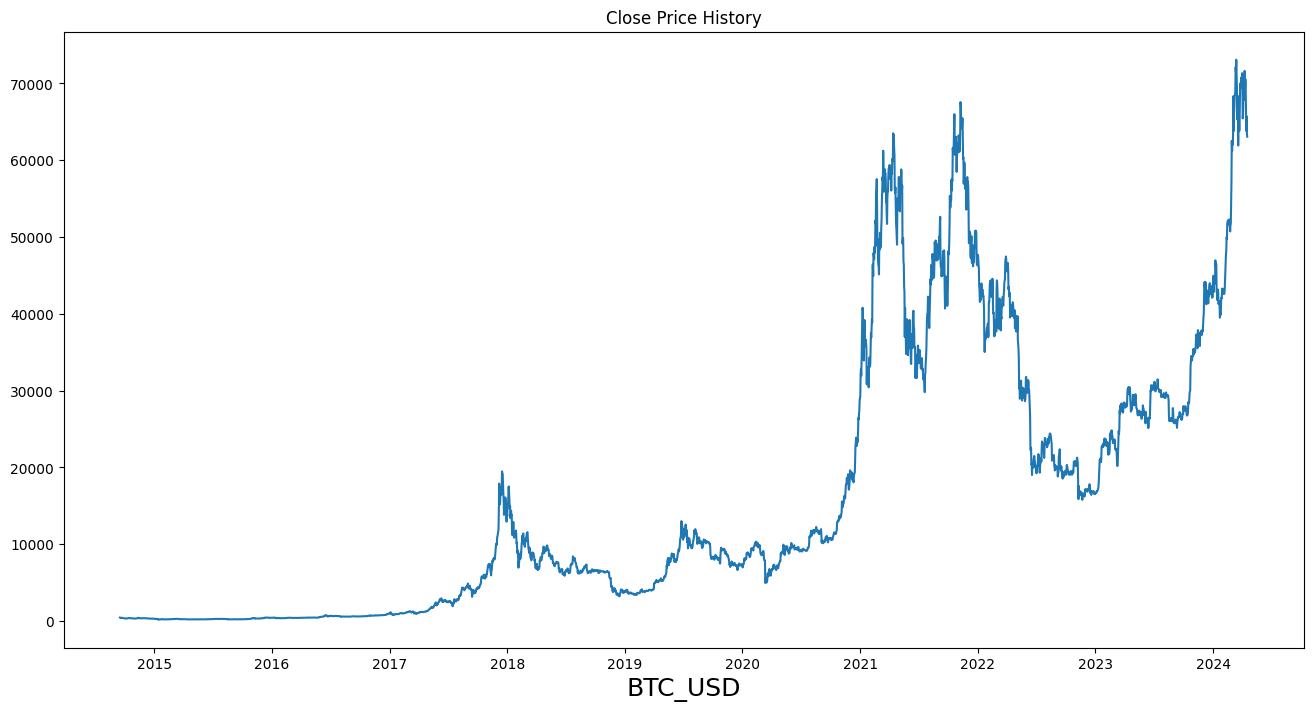

In [9]:
# Plot Close Price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_orig['Close'])
plt.xlabel(f'{symbol}',fontsize=18)
plt.show()

### Feature Engineering - Feature Expansion

##### Indicators

In [10]:
# Apply All Technical Analysis Features
df_ta = extractor.get_all_ta_features(df_orig)
df_ta

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,-7.924336e+06,21056800,-0.376331,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,457.334015,0.000000,0.000000,0.000000
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-2.454020e+07,-13426400,-0.441847,-1.134291e+09,...,-0.576839,-0.115368,-0.461471,4.857081,0.971416,3.885665,438.878342,-7.192558,-7.464335,-7.192558
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-4.448391e+07,-51346100,-0.475969,-1.132834e+09,...,-1.557290,-0.403752,-1.153538,9.351817,2.647496,6.704321,415.704003,-6.984265,-7.240151,-13.674475
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,-3.937687e+07,-14482500,-0.302148,-8.967045e+08,...,-2.067514,-0.736505,-1.331009,12.071627,4.532323,7.539305,411.993490,3.573492,3.511124,-10.589639
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-5.037763e+07,-41062600,-0.321074,-8.068905e+08,...,-2.636293,-1.116462,-1.519831,10.907564,5.807371,5.100193,404.904204,-2.465854,-2.496766,-12.794369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,67195.867188,44129299406,4.877163e+12,1709786867416,0.048106,-1.736097e+13,...,1.372354,1.816554,-0.444200,-4.934916,-8.502406,3.567491,68196.742802,-4.088948,-4.174897,14592.951978
2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,63821.472656,52869738185,4.868058e+12,1656917129231,0.001419,-4.036703e+13,...,0.665780,1.586399,-0.920620,-0.622363,-6.926398,6.304035,68113.451472,-5.021729,-5.152205,13855.111708
2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,65738.726562,49084320047,4.914817e+12,1706001449278,0.038600,-2.115644e+13,...,0.326039,1.334327,-1.008288,1.803093,-5.180500,6.983592,68051.036953,3.004089,2.959850,14274.335698


### Assess Data for ML Readiness

In [11]:
# Check for NaN
df_ta.dropna(inplace=True)
print(df_ta.isnull().values.any())

False


In [12]:
# Check for Inf values
dfobj = df_ta.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [13]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3500 entries, 2014-09-17 to 2024-04-16
Data columns (total 92 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       3500 non-null   float64
 1   High                       3500 non-null   float64
 2   Low                        3500 non-null   float64
 3   Close                      3500 non-null   float64
 4   Adj Close                  3500 non-null   float64
 5   Volume                     3500 non-null   int64  
 6   volume_adi                 3500 non-null   float64
 7   volume_obv                 3500 non-null   int64  
 8   volume_cmf                 3500 non-null   float64
 9   volume_fi                  3500 non-null   float64
 10  volume_em                  3500 non-null   float64
 11  volume_sma_em              3500 non-null   float64
 12  volume_vpt                 3500 non-null   float64
 13  volume_vwap                350

In [14]:
df_ta.describe()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3.500000e+03,3.500000e+03,3.500000e+03,3500.000000,3.500000e+03,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,15822.352528,16192.679365,15426.893184,15838.982023,15838.982023,1.710320e+10,1.654818e+12,7.127851e+11,0.076004,1.118083e+11,...,0.812903,0.812125,0.000778,0.633030,0.635551,-0.002521,15856.581305,0.209250,0.140756,3363.329100
std,17539.412459,17961.342978,17073.763348,17553.169449,17553.169449,1.928737e+10,1.868843e+12,7.428675e+11,0.155576,1.360624e+13,...,4.508325,4.289241,1.241977,9.595949,8.294747,4.314684,17502.718820,3.682834,3.710812,3838.150865
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,-4.322434e+08,-3.328073e+08,-0.475969,-1.743560e+14,...,-14.987100,-12.071342,-5.521671,-26.701844,-20.734601,-15.150410,226.312723,-37.169539,-46.473018,-61.056254
25%,1005.537521,1033.744995,981.305008,1006.747482,1006.747482,2.075270e+08,7.325556e+09,6.985334e+09,-0.035064,-3.676758e+11,...,-1.807086,-1.720677,-0.685149,-5.859271,-4.785399,-2.649442,1035.648861,-1.242900,-1.250689,120.133961
50%,8660.375977,8831.566895,8392.174805,8660.093750,8660.093750,1.274570e+10,6.118715e+11,4.540555e+11,0.072852,2.889059e+07,...,0.566711,0.573257,0.005854,-0.026473,0.168837,-0.255754,8635.453285,0.138790,0.138694,1793.603683
75%,26724.530762,27092.020508,26330.320312,26753.939941,26753.939941,2.754272e+10,4.103133e+12,1.315316e+12,0.186548,8.083680e+11,...,3.405740,3.403944,0.728291,6.126667,5.235497,2.274012,26798.581876,1.720138,1.705511,5749.978149
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11,4.914817e+12,2.687295e+12,0.673299,1.324494e+14,...,19.598952,17.933404,4.956753,51.910225,36.258881,21.383202,68215.430193,25.247169,22.511895,15880.333328


### Add Prediction Target

In [15]:
# Specify Target
df_ta['TARGET'] = df_ta['Close'].shift(-1)
df_target = df_ta.copy()
df_target[['Close', 'TARGET']]

,Close,TARGET
Date,,
2014-09-17,457.334015,424.440002
2014-09-18,424.440002,394.795990
2014-09-19,394.795990,408.903992
2014-09-20,408.903992,398.821014
2014-09-21,398.821014,402.152008
...,...,...
2024-04-12,67195.867188,63821.472656
2024-04-13,63821.472656,65738.726562
2024-04-14,65738.726562,63426.210938


In [16]:
# Check for NaNs
nan_location = np.where(pd.isna(df_target))
nan_location

(array([3499], dtype=int64), array([92], dtype=int64))

In [17]:
# Remove last row to avoid NaNs
df_target.dropna(inplace=True)
df_target.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-11,70575.734375,71256.234375,69571.812500,70060.609375,70060.609375,30153382941,4.892586e+12,1753916166822,0.061950,8.153791e+11,...,1.927604,-0.175937,-8.044224,-9.394279,1.350055,68215.430193,-0.746974,-0.749778,15219.352397,67195.867188
2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,67195.867188,44129299406,4.877163e+12,1709786867416,0.048106,-1.736097e+13,...,1.816554,-0.444200,-4.934916,-8.502406,3.567491,68196.742802,-4.088948,-4.174897,14592.951978,63821.472656
2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,63821.472656,52869738185,4.868058e+12,1656917129231,0.001419,-4.036703e+13,...,1.586399,-0.920620,-0.622363,-6.926398,6.304035,68113.451472,-5.021729,-5.152205,13855.111708,65738.726562
2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,65738.726562,49084320047,4.914817e+12,1706001449278,0.038600,-2.115644e+13,...,1.334327,-1.008288,1.803093,-5.180500,6.983592,68051.036953,3.004089,2.959850,14274.335698,63426.210938
2024-04-15,65739.648438,66878.648438,62332.070312,63426.210938,63426.210938,43595917654,4.892204e+12,1662405531624,0.026801,-3.253641e+13,...,1.023690,-1.242550,2.516617,-3.641076,6.157693,67854.147153,-3.517737,-3.581100,13768.684347,63062.316406


### Train Test Split

In [18]:
# Remove unwanted columns
df_tts = df_target.copy()
df_tts.drop(columns=["Close", "Open", "High", "Low", "Adj Close"], inplace=True)

In [19]:
# Split into Learning (X) and Target (y) Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [20]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (2799, 87)
Shape of y_train:  (2799,)


### Build Initial Model

In [21]:
# Select type of model to optimize for
objective='reg:squarederror'
eval_metric=["rmse", "mae"]

In [22]:
# Build First Regression Model
model_0 = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=1,
    objective=objective,
    eval_metric=eval_metric
)


### Find Hyperparameters

In [23]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [24]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=model_0, param_distributions=param_grid, scoring='r2')
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

### Train Model

In [ ]:
# Build Regression Model 1
model_1 = XGBRegressor(
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    objective=objective,
    eval_metric=eval_metric
)


In [ ]:
# Fit Model
eval_set = [(X_train, y_train)]
model_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse', 'mae'], feature_types=None, gamma=12,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Performance Evaluation (Quick Overview)

In [ ]:
# Get predictions for training data
train_yhat = model_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [1801.8544  2227.6348   383.94586  383.44543  234.30139]


In [ ]:
# Get predictions for training data
train_yhat = model_1.predict(X_test)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [2148.104   376.0182 3457.5977 1615.3817  730.4726]


In [ ]:
# KFold Cross Validation
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)

In [ ]:
# Training and Test Results
train_results = cross_val_score(model_1, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
test_score = model_1.score(X_test, y_test) 

In [ ]:
# Report Results
print("Training R^2 scores from CV:", train_results)
print("Average Training R^2 score:", train_results.mean())
print("Test R^2 score:", test_score)

Training R^2 scores from CV: [0.99344226 0.99600089 0.9927579  0.9950866  0.9943089 ]
Average Training R^2 score: 0.9943193095028949
Test R^2 score: 0.9948205292800992


### Feature Selection

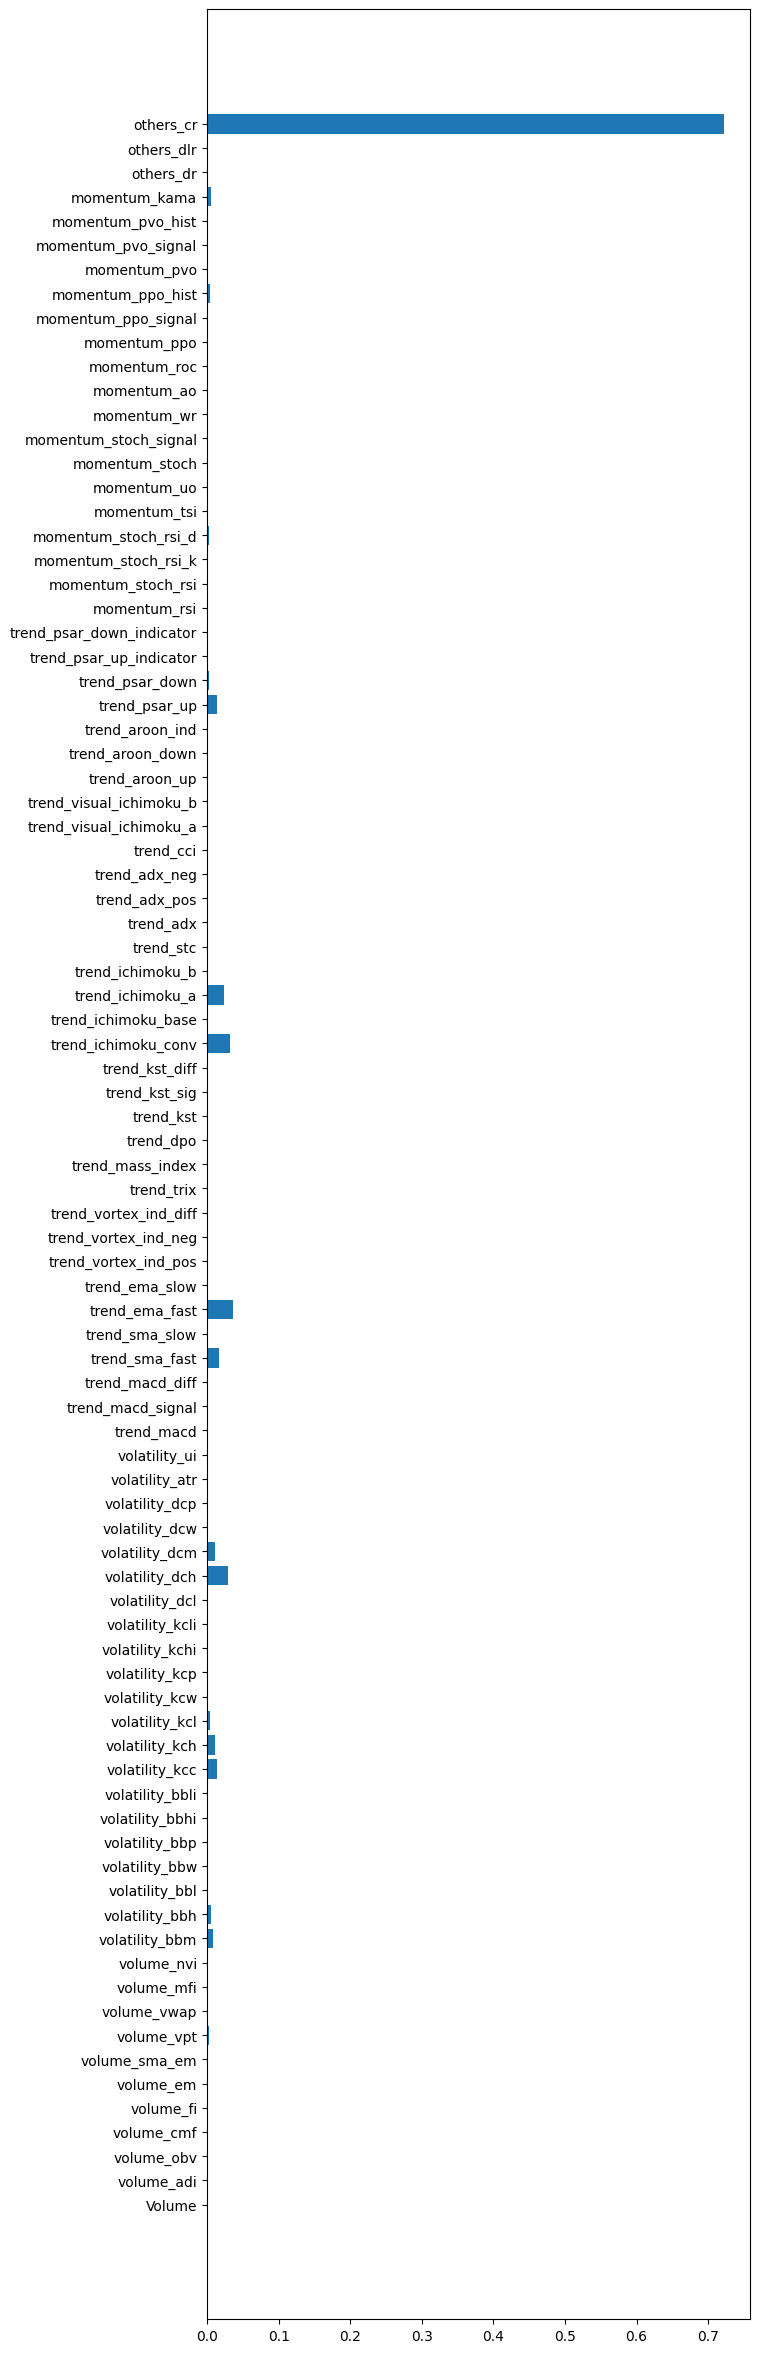

In [ ]:
# Plot Feature Importances
fig = plt.figure(figsize=(7, 30))
importance_labels = X.columns
importance_features = model_1.feature_importances_
plt.barh(importance_labels, importance_features)
plt.show()

In [ ]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

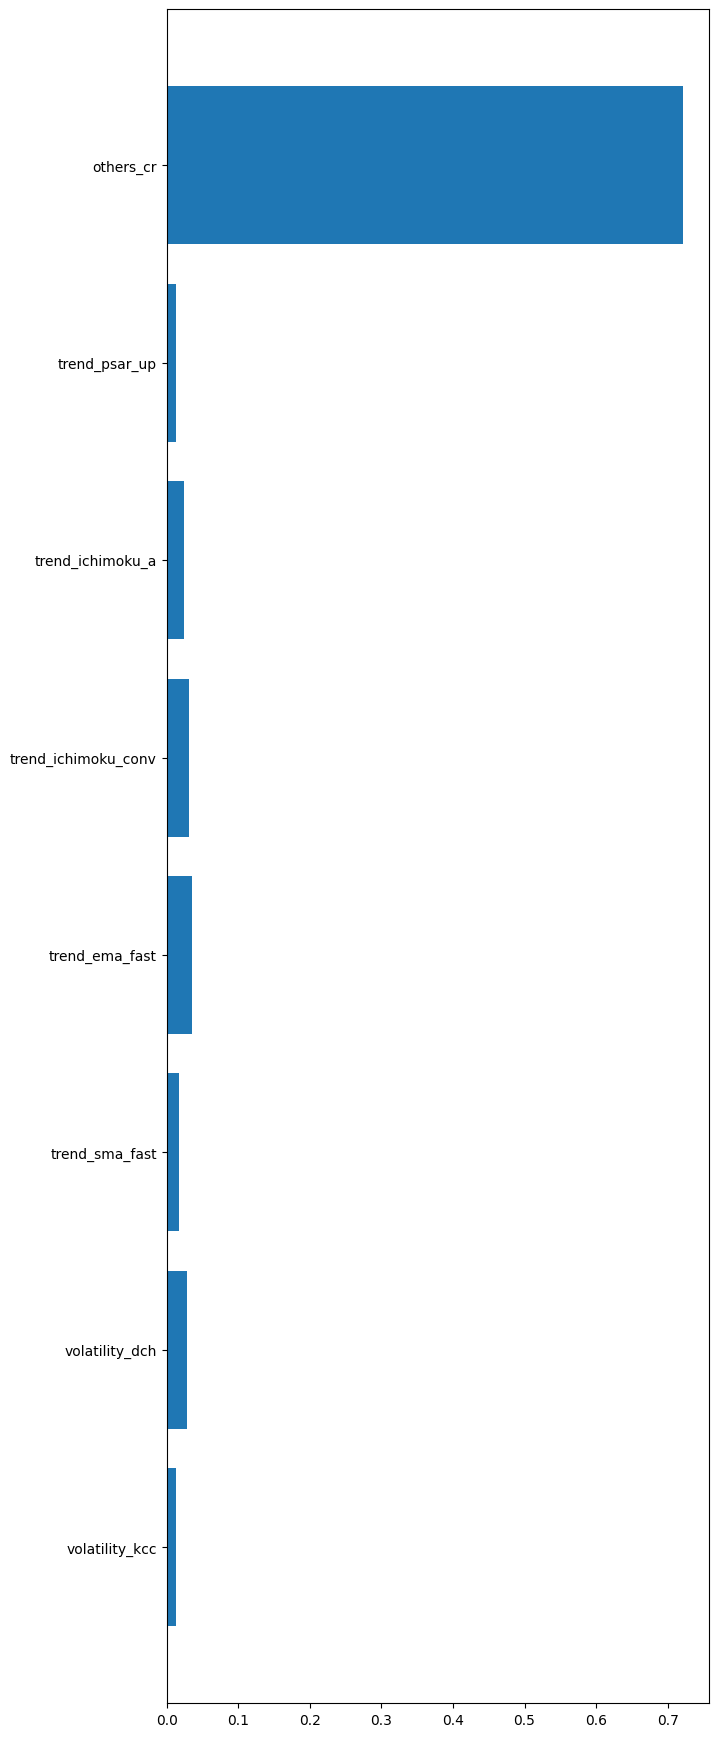

In [ ]:
# Plot Recommended Features
fig = plt.figure(figsize=(7, 22))
plt.barh(recommended_feature_labels, recommended_feature_score)
plt.show()

### Train Test Split
with recommended features

In [ ]:
df_tts2 = df_tts[recommended_feature_labels + ["TARGET"] ]

In [ ]:
# Split into X and Y Data
X = df_tts2.iloc[:, : -1]
y = df_tts2.iloc[:, -1]
print(X)

            volatility_kcc  volatility_dch  trend_sma_fast  trend_ema_fast  \
Date                                                                         
2017-11-09      319.130666      329.451996      320.884003      320.884003   
2017-11-10      312.650828      329.451996      310.068497      317.556155   
2017-11-11      312.025662      329.451996      311.605998      317.113823   
2017-11-12      311.150414      329.451996      310.681496      315.697541   
2017-11-13      312.397398      329.451996      311.888397      315.854228   
...                    ...             ...             ...             ...   
2024-04-18     3229.192269     3727.616455     3278.757365     3204.145632   
2024-04-19     3174.858805     3727.616455     3245.906026     3181.858391   
2024-04-20     3135.847176     3727.616455     3201.100566     3178.130515   
2024-04-21     3098.038298     3727.616455     3171.277669     3173.385601   
2024-04-22     3087.059115     3727.616455     3142.770589     3

In [ ]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1649, 8)
Shape of y_train:  (1649,)
Shape of X_test:  (708, 8)
Shape of y_test:  (708,)
Size Matches:  True


### Build Model

In [ ]:
# XGBOOST Regression Model 2
model_2 = XGBRegressor(
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    objective=objective,
    eval_metric=eval_metric
)

In [ ]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
model_2.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse', 'mae'], feature_types=None, gamma=12,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Make Predictions

In [ ]:
# Get Predictions Training
train_yhat = model_2.predict(X_train)
print("Preds Training Data: \n", train_yhat[:10])

Preds Training Data: 
 [314.84125 297.449   314.84125 300.95868 314.84125 332.43106 332.43106
 332.43106 332.43106 351.60837]


In [ ]:
# Get Predictions Test
test_yhat = model_2.predict(X_test)
print("Preds Test Data: \n", test_yhat[:10])

Preds Test Data: 
 [2001.2389 2062.0823 1919.0151 2024.3529 2029.733  2022.0483 2082.8918
 2022.0483 2022.0483 1939.3887]


In [ ]:
mse = mean_squared_error(y_test, test_yhat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_yhat)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 6982.489920606453
RMSE: 83.56129439283748
MAE: 59.14045542916335


In [ ]:
# Retrieve performance metrics
results = model_2.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

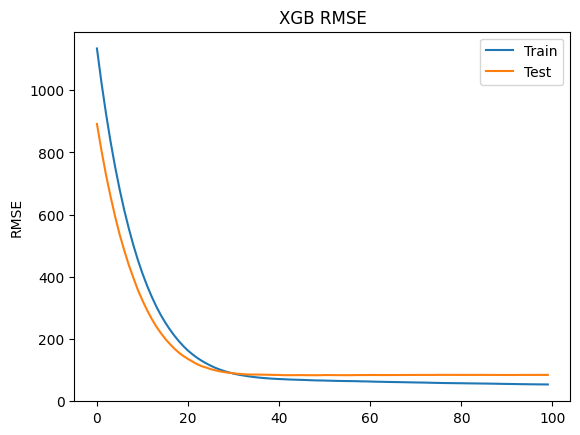

In [ ]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test")
ax.legend()
plt.ylabel("RMSE")
plt.title("XGB RMSE")
plt.show()

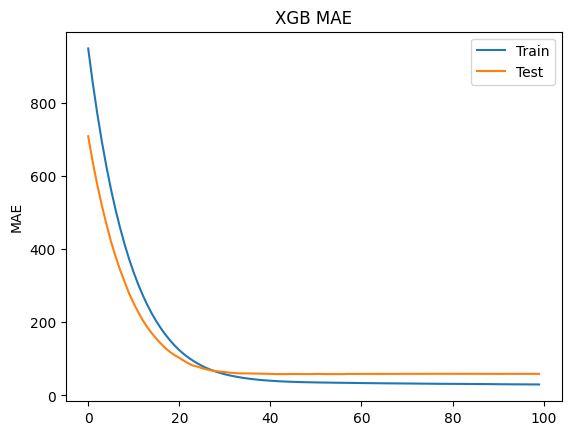

In [ ]:
# Plot error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["mae"], label="Train")
ax.plot(x_axis, results["validation_1"]["mae"], label="Test")
ax.legend()
plt.ylabel("MAE")
plt.title("XGB MAE")
plt.show()

In [ ]:
# Set K-Fold Cross Validation Levels
cv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits based on your dataset size and chronological ordering


In [ ]:
# Training and Test Results
train_results = cross_val_score(model_2, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
test_score = model_2.score(X_test, y_test) 

KeyboardInterrupt: 

In [ ]:
print("Training R^2 scores from CV:", train_results)
print("Average Training R^2 score:", train_results.mean())
print("Test R^2 score:", test_score)

Training R^2 scores from CV: [-0.70462823 -0.64694778  0.51172025  0.95656213 -0.16422039]
Average Training R^2 score: -0.009502804463047609
Test R^2 score: 0.938796478604407


In [ ]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, train_yhat))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, train_yhat))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_train, train_yhat)))
print("R-squared (R^2):", r2_score(y_train, train_yhat))

Mean Absolute Error (MAE): 235.9937042074332
Mean Squared Error (MSE): 272802.8633621275
Root Mean Squared Error (RMSE): 522.3053353758963
R-squared (R^2): 0.9979780437894048


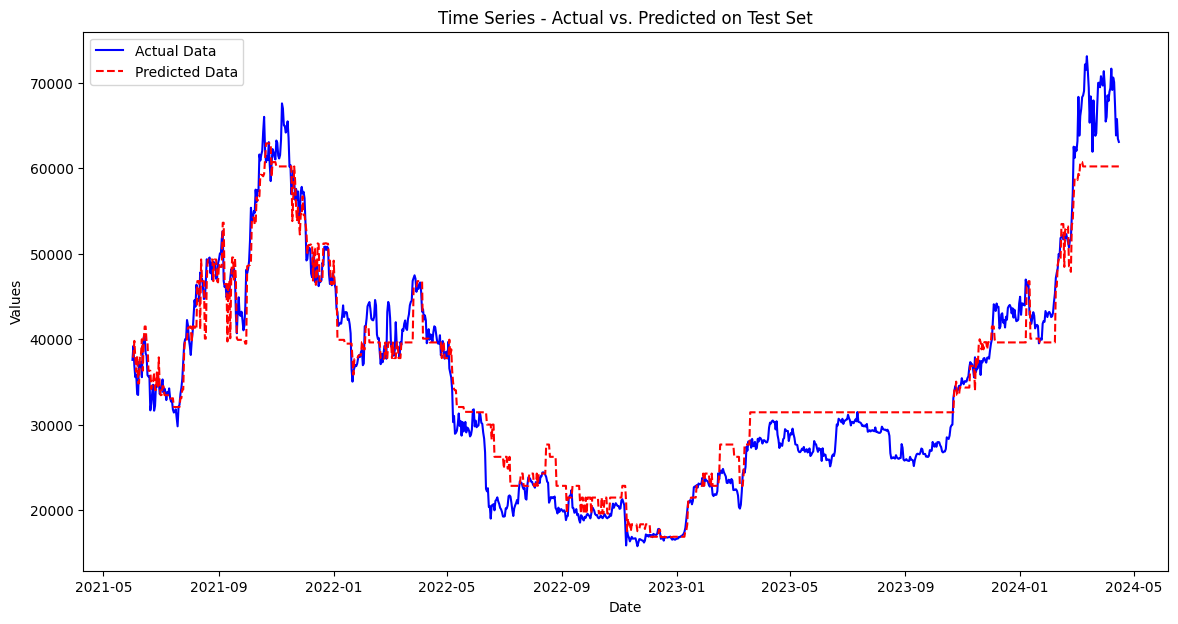

In [ ]:
# Plot Actual vs. Predicted

# Convert the test predictions to a pandas Series
test_yhat_series = pd.Series(test_yhat, index=y_test.index)

# Plot the actual data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')

# Plot the predicted data
plt.plot(test_yhat_series.index, test_yhat_series, label='Predicted Data', color='red', linestyle='--')

# Add titles and labels
plt.title('Time Series - Actual vs. Predicted on Test Set')
plt.xlabel('Date')
plt.ylabel('Values')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
print(y.index.max())
print(y_test.index.max())
print(y_train.index.max())

2024-04-15 00:00:00
2024-04-15 00:00:00
2021-05-31 00:00:00


### Feature Importance

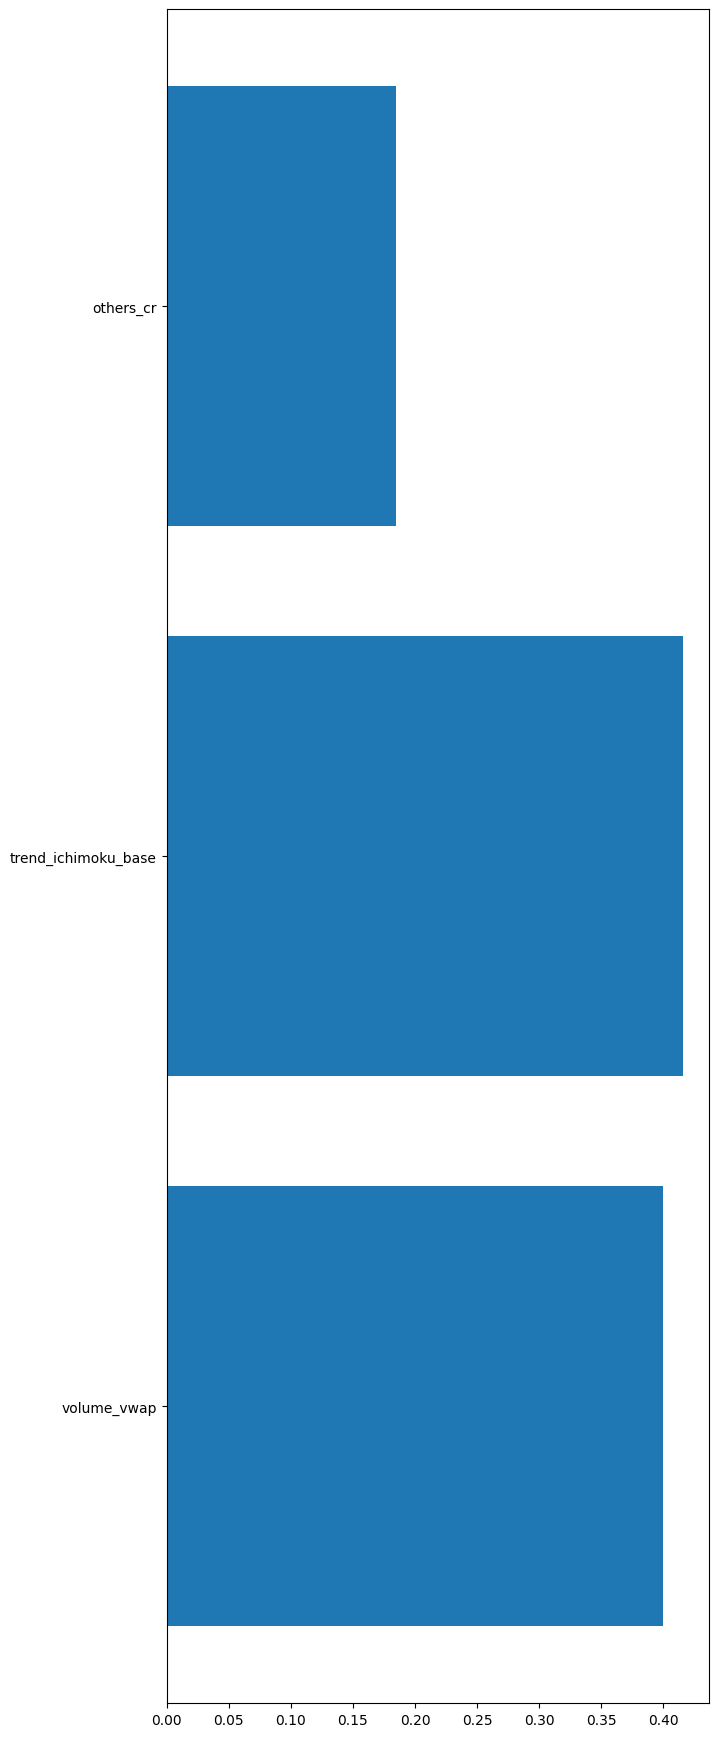

In [ ]:
# Plot Feature Importances
fig = plt.figure(figsize=(7, 22))
importance_labels = X.columns
importance_features = model_2.feature_importances_
plt.barh(importance_labels, importance_features)
plt.show()

<Axes: >

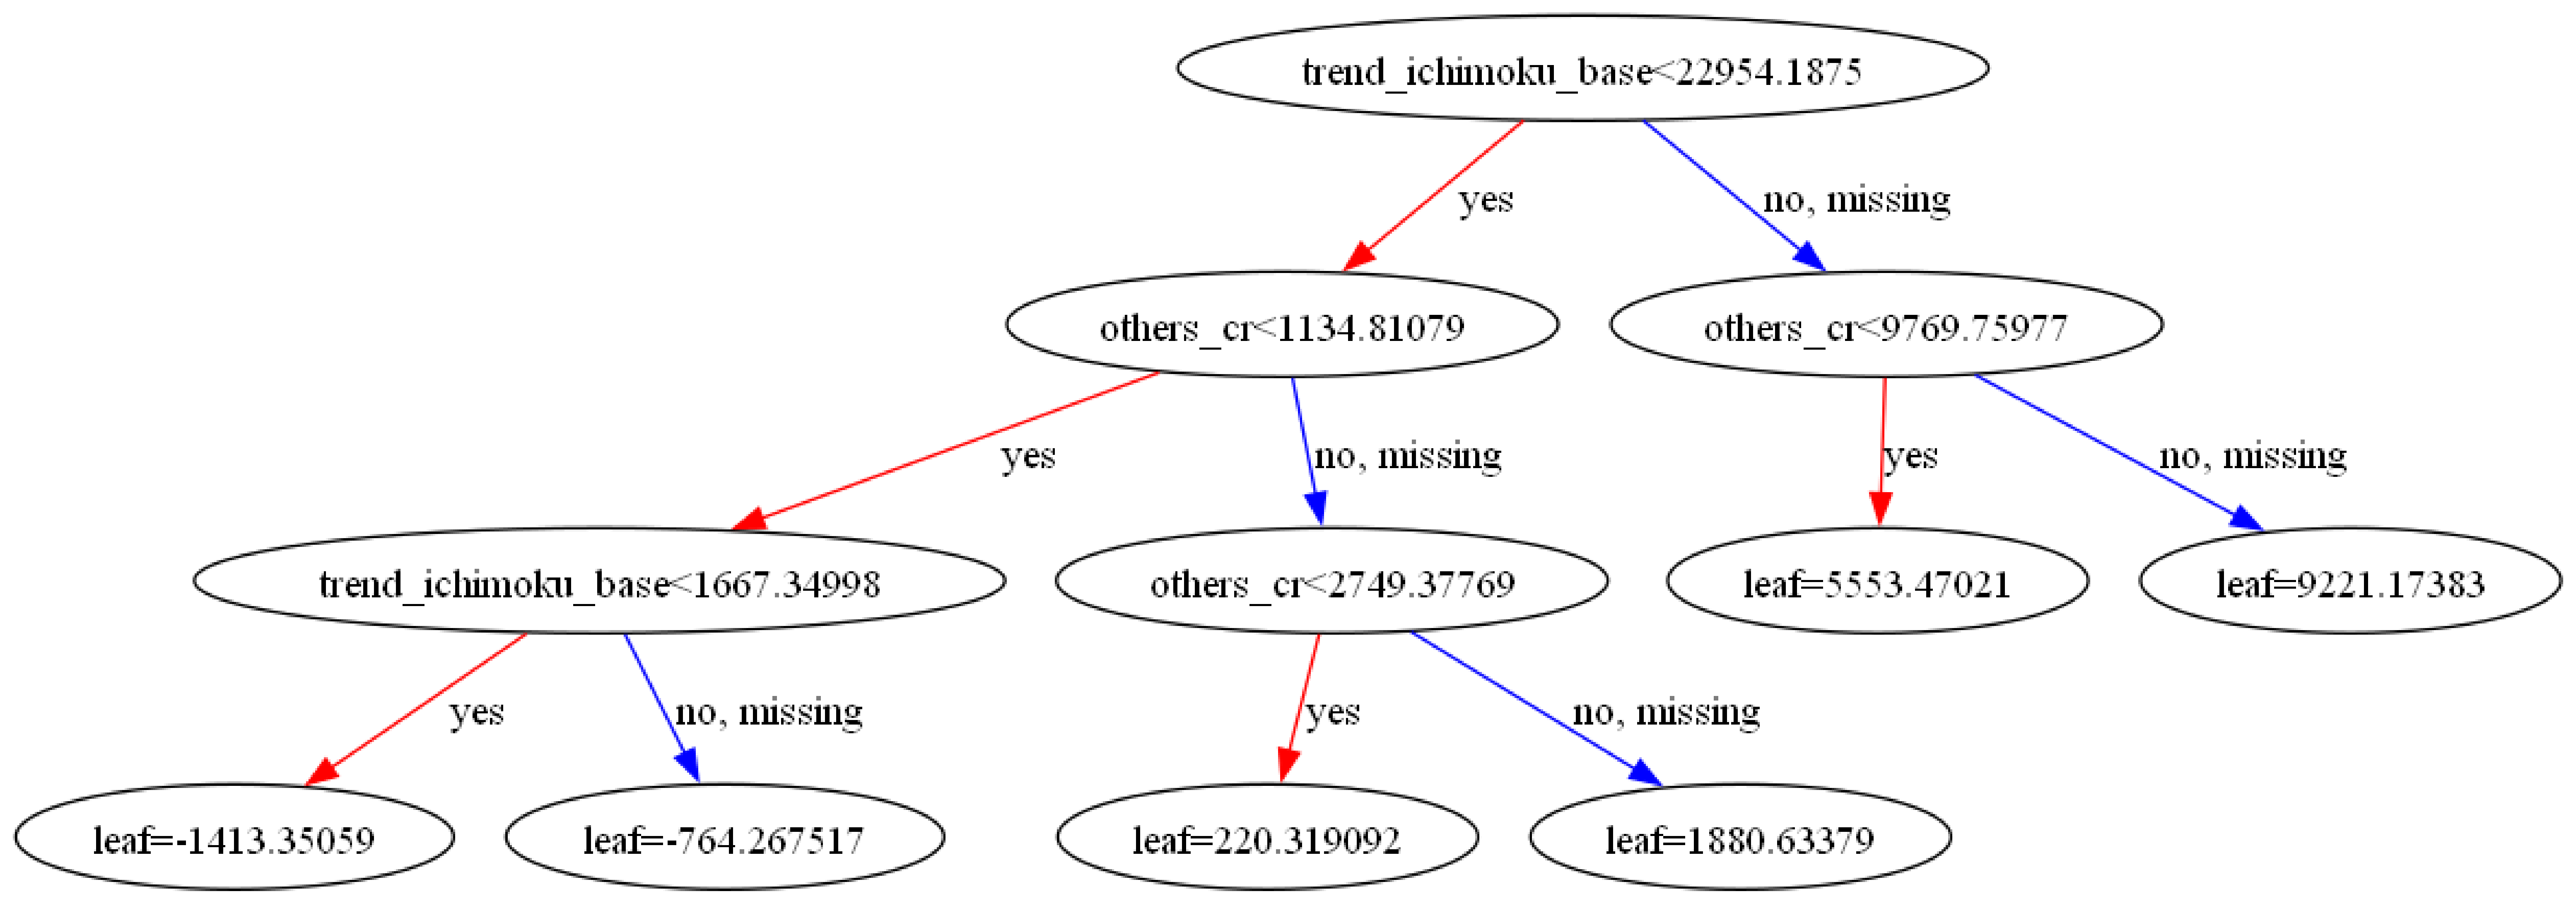

In [ ]:
rcParams["figure.figsize"] = 80, 50
plot_tree(model_2)